# 项目：未前往就诊的挂号预约

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>
## 简介
本数据集包含10万条巴西预约挂号的求诊信息，研究病人是否如约前往医院就诊。每行数据录入了有关患者特点的多个数值，包括 “预约日期 (ScheduledDay)”指患者具体预约就诊的日期；“街区 (Neighborhood) ”指医院所在位置；“福利保障 (Scholarship)”说明病人是否是巴西福利项目 Bolsa Família 的保障人群；

 - *请注意最后一列内容的编码：“No”表示病人已如约就诊，“Yes”说明病人未前往就诊。*

### 问题：有哪些重要因素能够帮助我们预测患者是否会按照其挂号预约前往医院就诊？

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='wrangling'></a>
## 数据整理

### 常规属性

In [2]:
#  加载数据
df = pd.read_csv("noshowappointments-kagglev2-may-2016.csv")
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


通过数据的info，可以看出总共有110527条数据，且没有缺失的数据

In [4]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


观察数据描述发现其中有一条异常数据，Age=-1，稍后清理掉

In [5]:
# 检查是否有重复数据
sum(df.duplicated())

0

规范命名

In [6]:
# 重命名No-show
df.rename(index=str, columns={'No-show':'No_show'}, inplace=True)
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No_show'],
      dtype='object')

### 清理异常及用不到的数据

- 删除年龄异常的数据，年龄小于0

In [7]:
df.query("Age < 0")

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


In [8]:
df = df[df.Age >= 0]
df.shape

(110526, 14)

In [9]:
df.query("Age < 0")

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show


- 删除用不到的列PatientId，AppointmentID，ScheduledDay，AppointmentDay

In [10]:
df.drop(['PatientId','AppointmentID','ScheduledDay','AppointmentDay'], axis=1, inplace=True)
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [11]:
# 观察地区的值
len(df.Neighbourhood.value_counts())

81

地区比较多，先忽略

In [12]:
df.drop('Neighbourhood', axis=1, inplace=True)
df.head()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,F,62,0,1,0,0,0,0,No
1,M,56,0,0,0,0,0,0,No
2,F,62,0,0,0,0,0,0,No
3,F,8,0,0,0,0,0,0,No
4,F,56,0,1,1,0,0,0,No


- 给年龄分区，[29,39,49] [青年，中青年，中年，中老年]

In [13]:
df["Age"] = pd.cut(df.Age, [-1,29,39,49,130], labels=['youth','elder_youth','middle_aged','elder'])
df.head(5)

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,F,elder,0,1,0,0,0,0,No
1,M,elder,0,0,0,0,0,0,No
2,F,elder,0,0,0,0,0,0,No
3,F,youth,0,0,0,0,0,0,No
4,F,elder,0,1,1,0,0,0,No


- 把 No_show 转化为 0，1的bool值，可以通过求No_show的平均值求的预约未就诊率

In [14]:
df.No_show = df.No_show == 'Yes'
df.No_show.head()

0    False
1    False
2    False
3    False
4    False
Name: No_show, dtype: bool

保存清理后的数据

In [15]:
df.to_csv('noshowappointment_edited.csv', index=False)

df_clean = pd.read_csv('noshowappointment_edited.csv')
df_clean.head()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,F,elder,0,1,0,0,0,0,False
1,M,elder,0,0,0,0,0,0,False
2,F,elder,0,0,0,0,0,0,False
3,F,youth,0,0,0,0,0,0,False
4,F,elder,0,1,1,0,0,0,False


<a id='eda'></a>
## 探索性数据分析


### 性别对预测预约就诊率有帮助吗？

In [16]:
# 加载数据
df_clean = pd.read_csv('noshowappointment_edited.csv')
df_clean.head()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,F,elder,0,1,0,0,0,0,False
1,M,elder,0,0,0,0,0,0,False
2,F,elder,0,0,0,0,0,0,False
3,F,youth,0,0,0,0,0,0,False
4,F,elder,0,1,1,0,0,0,False


In [17]:
df_clean.Gender.value_counts()

F    71839
M    38687
Name: Gender, dtype: int64

In [18]:
df_gender = df_clean.groupby('Gender')["No_show"].mean()
df_gender

Gender
F    0.203149
M    0.199679
Name: No_show, dtype: float64

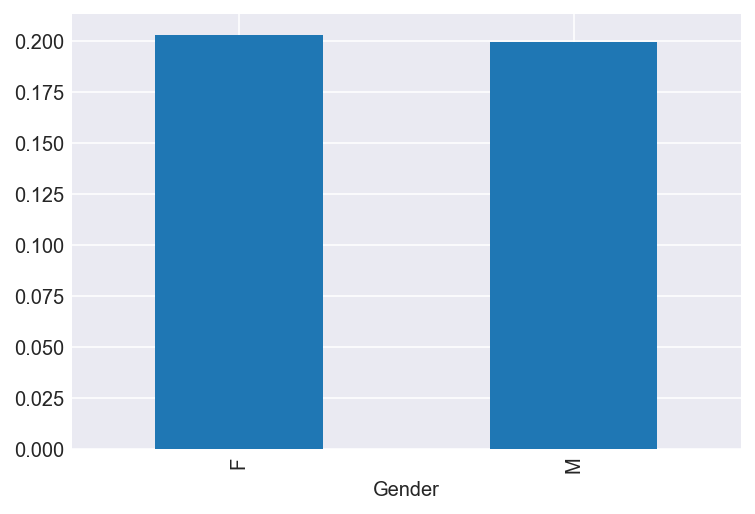

In [19]:
df_gender.plot.bar();

> 答：通过比较数据可以看出 女性未就诊率为20.31%，而男性未就诊率为19.97%,没有太大的差异，可以认为基本上无法通过性别预测就诊率

### 年龄可以预测就诊率吗？那个年龄层的人未就诊率比较低？

In [20]:
df_age = df_clean.groupby('Age')["No_show"].mean()
df_age = df_age.sort_values()
df_age

Age
elder          0.162491
middle_aged    0.202688
elder_youth    0.217520
youth          0.229449
Name: No_show, dtype: float64

可视化结果

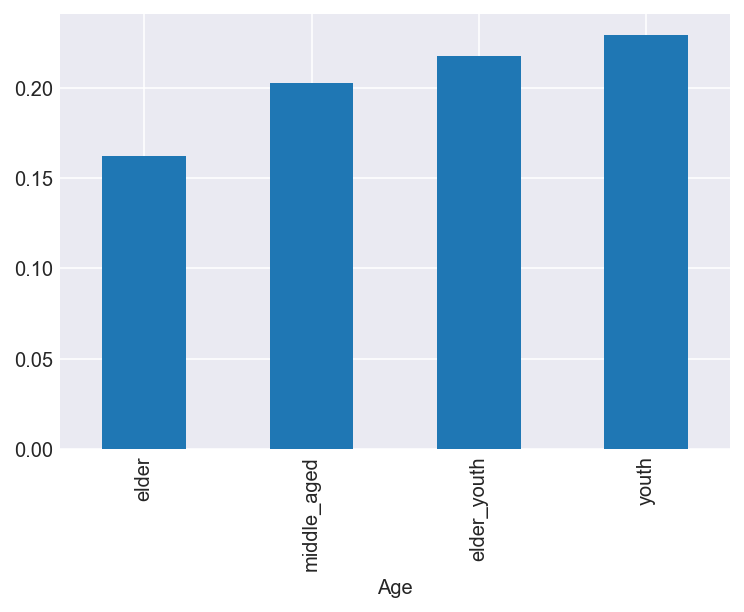

In [21]:
df_age.plot.bar();

> 答：从上图可以看出，年龄越大，未就诊率越低，而中老年人未就诊率最低。
<br>年龄是一个预测就诊率的因素

### 其他因素呢？

In [23]:
df.columns

Index(['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes',
       'Alcoholism', 'Handcap', 'SMS_received', 'No_show'],
      dtype='object')

剩余还没进行比较的数据有 ['Scholarship', 'Hipertension', 'Diabetes','Alcoholism', 'Handcap','SMS_received']

In [24]:
# 分别取出未就诊，和已就诊的数据
df_show = df_clean.query('No_show == False')
df_no_show = df_clean.query('No_show == True')

删除这个问题用不到的数据

In [25]:
df_show = df_show.drop(['Gender', 'Age','No_show'], axis=1)
df_show.head()

,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
0,0,1,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,1,1,0,0,0


In [26]:
df_no_show = df_no_show.drop(['Gender', 'Age','No_show'], axis=1)
df_no_show.head()

,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
6,0,0,0,0,0,0
7,0,0,0,0,0,0
11,0,0,0,0,0,1
17,1,0,0,0,0,0
20,0,0,0,0,0,0


在一个图标中绘制未就诊和已就诊的不同参数的比率

In [27]:
labels = df_show.columns
ind = np.arange(len(labels))
width = 0.35
labels

Index(['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received'],
      dtype='object')

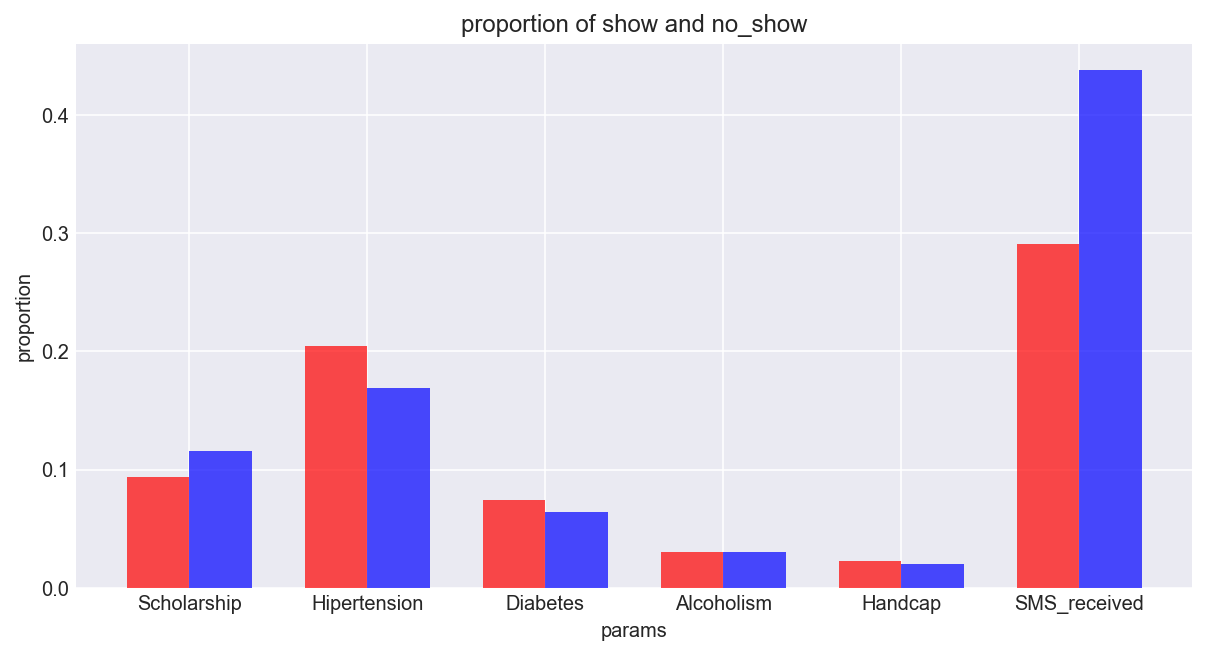

In [28]:
plt.figure(figsize=(10,5))
show_bar = plt.bar(ind, df_show.mean(), width, color='r', alpha=.7)
no_show_bar = plt.bar(ind+width, df_no_show.mean(), width, color='b', alpha=.7)
plt.ylabel('proportion')
plt.xlabel('params')
plt.title('proportion of show and no_show')
locations = ind + width/2
plt.xticks(locations, labels)

plt.legend()

> 答：从上面柱状图可以看出，未就诊的和就诊相比，福利保障比例高一些，高血压比例低一些，糖尿病比例低一些，酗酒比例基本一致，残障比例低一些，收到短信的比例高一些。<br>
所以，福利保障、高血压、糖尿病、残障、是否收到短信等因素可以用于预测是否未就诊。

<a id='conclusions'></a>
## 结论

#### 通过上面的数据分析可以得出这样的结论，年龄、福利保障、高血压、糖尿病、残障、是否收到短信等因素均可以用来预测患者的未就诊率。其中年龄、高血压、糖尿病、残障跟未就诊率呈负相关，福利保障、是否收到短信跟未就诊率呈正相关。
